# Data format example

In [1]:
import pypesto
import amici
import numpy as np
import data_import

%matplotlib inline

## Import model

In [2]:
from importlib import reload
data_import = reload(data_import)

importer = data_import.Importer("Zheng_PNAS2012")

model = importer.model

print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')


Model parameters: ['inflowp', 'k00_01', 'k00_10', 'k01_00', 'k01_02', 'k01_11', 'k02_01', 'k02_03', 'k02_12', 'k03_02', 'k03_13', 'k10_00', 'k10_11', 'k10_20', 'k11_01', 'k11_10', 'k11_12', 'k11_21', 'k12_02', 'k12_11', 'k12_13', 'k12_22', 'k13_03', 'k13_12', 'k13_23', 'k20_10', 'k20_21', 'k20_30', 'k21_11', 'k21_20', 'k21_22', 'k21_31', 'k22_12', 'k22_21', 'k22_23', 'k22_32', 'k23_13', 'k23_22', 'k30_20', 'k30_31', 'k31_21', 'k31_30', 'k31_32', 'k32_22', 'k32_31', 'noise'] 

Model const parameters: ['dilution'] 

Model outputs:    ['observable_K27me0K36me0', 'observable_K27me0K36me1', 'observable_K27me1K36me0', 'observable_K27me0K36me2', 'observable_K27me1K36me1', 'observable_K27me2K36me0', 'observable_K27me0K36me3', 'observable_K27me1K36me2', 'observable_K27me2K36me1', 'observable_K27me3K36me0', 'observable_K27me1K36me3', 'observable_K27me2K36me2', 'observable_K27me3K36me1', 'observable_K27me2K36me3', 'observable_K27me3K36me2'] 

Model states:     ['K27me0K36me0', 'K27me0K36me1', 'K2

## Create objective function

In [3]:
obj, edatas = importer.create_objective()
obj(importer.par_nominal_values)

-277.4723184649393

## Run optimization

In [4]:
optimizer = pypesto.ScipyOptimizer()

problem = pypesto.Problem(objective=obj, 
                          lb=importer.par_lb, ub=importer.par_ub,
                          x_names=importer.par_ids)

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=10)

## Visualization

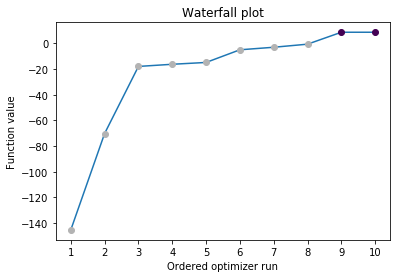

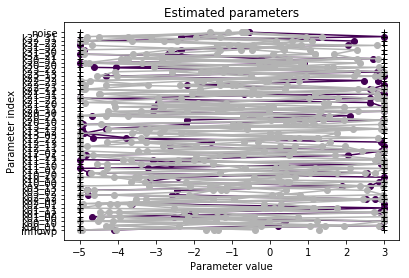

In [5]:
import pypesto.visualize

pypesto.visualize.waterfall(result)
pypesto.visualize.parameters(result)

In [6]:
rdata = 

SyntaxError: invalid syntax (<ipython-input-6-3e0a79e7710e>, line 1)